In [15]:
import os
import pickle
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [3]:
# Read dataset
processed_data = os.path.abspath('../datasets/processed_data.csv')

# Merging two csv files
data = pd.read_csv(processed_data)

data.head()

,Location,Day,Hour,AQI,PM2.5,PM10,O3,CO,SO2,NO2,AQI_Class
0,0,26,18,48,24.0,47.0,17.0,210.0,13.0,14.0,a_Good
1,7,22,20,36,18.0,28.0,8.0,346.0,27.0,7.0,a_Good
2,0,28,18,37,19.0,37.0,18.0,272.0,11.0,21.0,a_Good
3,0,28,18,37,19.0,37.0,18.0,272.0,11.0,21.0,a_Good
4,0,27,18,47,24.0,46.0,19.0,216.0,8.0,14.0,a_Good


In [4]:
# Selecting features and target variable
X = data[['Location', 'Day', 'Hour', 'PM2.5', 'PM10', 'O3', 'CO', 'SO2', 'NO2']]
y = data['AQI']

# Data scaling
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
y = np.array(y).reshape(-1, 1)
y = scaler.fit_transform(y)

# Transform X for LSTM (3D format: samples, timesteps, features)
X = np.expand_dims(X, axis=1)

# Splitting into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
# Building an LSTM model for regression
model = Sequential([
    LSTM(128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.3),
    LSTM(64, activation='relu', return_sequences=False),
    Dropout(0.3),
    Dense(1, activation='linear')
])

print(model.summary())

/Users/macbook/.pyenv/versions/3.11.0/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 128)         │        70,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,129 (469.25 KB)

 Trainable params: 120,129 (469.25 KB)

 Non-trainable params: 0 (0.00 B)

None


In [6]:
# Model compilation
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

In [7]:
# Model training
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/50
306/306 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0648 - mean_absolute_error: 0.1809 - val_loss: 0.0107 - val_mean_absolute_error: 0.0714
Epoch 2/50
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0130 - mean_absolute_error: 0.0800 - val_loss: 0.0063 - val_mean_absolute_error: 0.0559
Epoch 3/50
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0097 - mean_absolute_error: 0.0696 - val_loss: 0.0043 - val_mean_absolute_error: 0.0471
Epoch 4/50
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0073 - mean_absolute_error: 0.0606 - val_loss: 0.0030 - val_mean_absolute_error: 0.0410
Epoch 5/50
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0058 - mean_absolute_error: 0.0545 - val_loss: 0.0023 - val_mean_absolute_error: 0.0350
Epoch 6/50
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0050 - mean_absolute_error: 0.0494 - val_loss: 0.0018 - val_mean_absolute_error: 0.0308
Epoch 7/50
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0044 - mean_absolute_error: 0.0468 - v

In [8]:
# Model evaluation
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test MAE: {mae:.2f}")

Test MAE: 0.01


In [9]:
# Prediction
y_pred = model.predict(X_test).flatten()

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [10]:
# Scaling predictions and test values ​​back to the original scale
y_test = scaler.inverse_transform(y_test)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

In [11]:
# Metrics evaluation
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R2 Score: {r2:.2f}")

MSE: 39.89
RMSE: 6.32
MAE: 4.51
R2 Score: 1.00


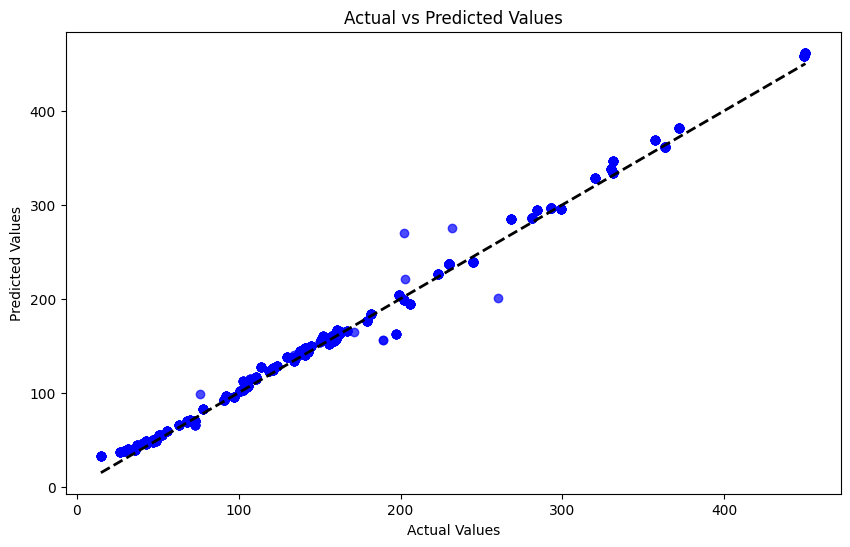

In [12]:
# Visualization of results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='b')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

In [13]:
# Saving the model
model.save("serialized/keras/lstmModel.keras")

In [16]:
# Creating an object to save
custom_object = {
    "model_path": "serialized/keras/lstmModel.keras",
    "additional_info": "This is an LSTM model for AQI classification"
}

# Saving an object in pickle
with open("serialized/LSTMModel.pkl", "wb") as f:
    pickle.dump(custom_object, f)